Get started _ Extract data directly from kaggle -- Account- Kaggle API download. https://towardsdatascience.com/medical-x-ray-%EF%B8%8F-image-classification-using-convolutional-neural-network-9a6d33b1c2a


In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images
#!kaggle kernels output gcdatkin/pneumonia-x-ray-classification-mobilenetv2 -p /path/to/dest

 99% 1.13G/1.14G [00:33<00:00, 21.5MB/s]
100% 1.14G/1.14G [00:33<00:00, 36.4MB/s]


In [3]:
import zipfile
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [17]:
# Basic Imports
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
#Define Directories for train, test & Validation Set
train_dir = '/content/dataset/cnn/pneumonia_revamped/train'
test_dir = '/content/dataset/cnn/pneumonia_revamped/test'
val_dir = '/content/dataset/cnn/pneumonia_revamped/val'


In [5]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32

Creating Data Generators. Used to generate the array of pixels of image. 

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # transformation of images
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [7]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 4192 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Mobile Net V2-- its a light weight, trained on image net dataset-- transfer learning

Building the Mode

In [8]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [10]:
EPOCHS = 50

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
131/131 [==============================] - 124s 842ms/step - loss: 0.2019 - accuracy: 0.9225 - auc: 0.9656 - val_loss: 0.1275 - val_accuracy: 0.9481 - val_auc: 0.9897
Epoch 2/50
131/131 [==============================] - 109s 834ms/step - loss: 0.1239 - accuracy: 0.9532 - auc: 0.9872 - val_loss: 0.1070 - val_accuracy: 0.9606 - val_auc: 0.9892
Epoch 3/50
131/131 [==============================] - 120s 921ms/step - loss: 0.1117 - accuracy: 0.9552 - auc: 0.9898 - val_loss: 0.1296 - val_accuracy: 0.9500 - val_auc: 0.9912
Epoch 4/50
131/131 [==============================] - 110s 844ms/step - loss: 0.0996 - accuracy: 0.9614 - auc: 0.9918 - val_loss: 0.1155 - val_accuracy: 0.9500 - val_auc: 0.9923
Epoch 5/50
131/131 [==============================] - 116s 886ms/step - loss: 0.0909 - accuracy: 0.9628 - auc: 0.9931 - val_loss: 0.1025 - val_accuracy: 0.9644 - val_auc: 0.9908
Epoch 6/50
131/131 [==============================] - 113s 866ms/step - loss: 0.0901 - accuracy: 0.9642 - auc:

In [14]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))

cm = confusion_matrix(true_labels, pred_labels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [15]:
test_data.class_indices

{'normal': 0, 'opacity': 1}

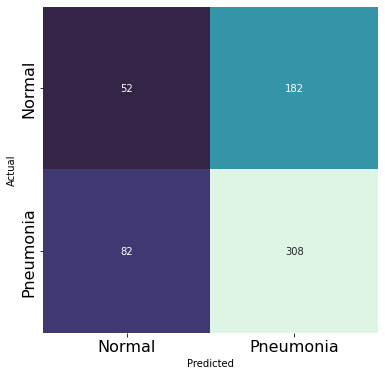

In [18]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [19]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [20]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [21]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.83
AUC: 0.94
Precision: 0.63
Recall: 0.79
